## A Practical Diffusion Path for Sampling

In this notebook, we will reproduce the experiment made by Anna Korba and O. Chebab in the article: "[A Practical Diffusion Path for Sampling](https://arxiv.org/abs/2406.14040)", 2024.

The main goal is to draw samples from complex target distribution. (...) On s'occupe de la rédaction ensuite car flemme sa mèèèèère


In [ ]:
## PACKAGE INSTALLATION

pip install autograd

In [81]:
## Importing standards libraries

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

## Importing libraries for the Gaussian Mixture Model

from scipy.stats import multivariate_normal

## Autograd packages

#import autograd.numpy as np
#from autograd import grad

## Convergence metrics

from scipy.stats import wasserstein_distance
from scipy.stats import entropy # KL-divergence

### I. Sampling a Gaussian Mixture with 16 modes

We will compare 3 methods to sample a target distribution which is a Gaussian Mixture with 16 modes : 
- Unadjusted Langevin Algorithm (ULA)
- ULA with geometric path 
- ULA with dilation path

We consider that sample from the target distribution are not available, which make the task of using diffusion models more complicated (except for the dilation path). 

Convergence metrics (aims to quantify the distance between intermediaries distributions and the target distribution) : DEFINE THEM
- KSD
- KL
- MMS

Parameters of the experiment : 
- 1000 particles 
- 10000 iterations
- step size of 0.001 (constant)

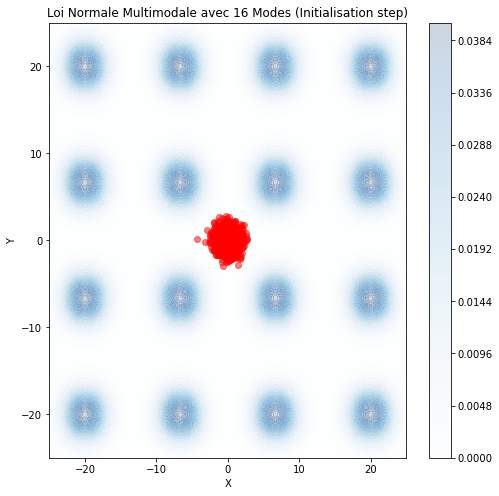

In [95]:
# Define the centers for each mode

x = np.linspace(-20, 20, 4)
y = np.linspace(-20, 20, 4)

## meshgrid : takes two 1D arrays and produces two 2D matrices corresponding to all pairs of (x, y) in the two arrays
xx, yy = np.meshgrid(x, y)

## ravel : returns a contiguous flattened array (Matrice to concatenated vector)
## np.c_ : prend en entrée des vecteurs et les concatène en une matrice à 2 colonnes

centers = np.c_[xx.ravel(), yy.ravel()] ## On a une matrice de 16 lignes et 2 colonnes, chaque ligne correspond à un centre

# Define the covariance matrix

covariance = np.array([[4, 0], [0, 4]])  # cov = 4*I_2

## dstack : stack arrays in sequence along the third axis (stocker les matrices les unes sur les autres) 
## ici pos[i, j] = [x[i], y[j]]

x_axis = np.linspace(-25, 25, 500)
y_axis = np.linspace(-25, 25, 500)

xx_axis, yy_axis = np.meshgrid(x_axis, y_axis)
pos = np.dstack((xx_axis, yy_axis))

# Compute the pdf for each center and sum them
pdf = np.zeros(xx_axis.shape)
for center in centers:
    rv = multivariate_normal(center, covariance) # On fixe la normale
    pdf += rv.pdf(pos) # On évalue la densité de cette loi sur la grille des points et on somme

## Initialisation : we draw a sample from a Standard Normal Distribution

sample = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], 1000)

x = sample[:, 0]
y = sample[:, 1]

# Plot the result

plt.figure(figsize=(8, 8))
plt.contourf(xx_axis, yy_axis, pdf, levels=50, cmap='Blues', alpha=0.2) 
## levels : nombre de niveaux de couleurs ; cmap : choix de la palette de couleurs ; alpha : transparence
plt.colorbar()

plt.scatter(x, y, alpha=0.5, color = 'red')
plt.title('Loi Normale Multimodale avec 16 Modes (Initialisation step)')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


We consider that we have access to the gradient of the score of the target distribution, which means that we can implement the ULA. 

We know that the score vector for a $ \mathcal{N}(\mu, \Sigma) $ is given by : 

$ \nabla \log p(x) = \Sigma^{-1}(x- \mu) $ 

As, a Multimodal Normal Distribution as a density that can be written as a weighted sum of $\mathcal{k}$ densities Multivariate Normal : 

$ f(x) = \sum_{i=1}^{k} w_i \cdot \mathcal{N}(x \mid \mu_i, \Sigma_i) $

where :

- $ (w_i)_{i:n} $ is the vector of weights of the $\mathcal{k}$ normal distributions 
- $\mathcal{N}(x \mid \mu_i, \Sigma_i) $ is the density of the i^th normal distribution which composes the multimodal
- $\sum_{i=1}^{k} w_i = 1 $, guarantees that the function is a density




------------------------------------------------------------------------------------------------------------------------------------------------------
Function to generate a graph of 2-dimensionnal Gaussian Mixture Distribution

In [93]:
def generate_multimodal(centers, covariances, weights, plot_sample=None): 

    n_components = len(weights)

    if n_components != len(centers) or n_components != len(covariances):
        raise ValueError('The number of centers, covariances and weights should be the same')
    
    graph_len = max(max(abs(centers[:, 0])),  max(abs(centers[:, 1]))) + 5

    x_axis = np.linspace(-graph_len, graph_len, 500)
    y_axis = np.linspace(-graph_len, graph_len, 500)

    xx_axis, yy_axis = np.meshgrid(x_axis, y_axis)
    pos = np.dstack((xx_axis, yy_axis))
    
    # Compute the pdf for each center and sum them

    pdf = np.zeros(xx_axis.shape)

    for i in range(n_components):
        center = centers[i]
        covariance = covariances[i]
        weight = weights[i]

        rv = multivariate_normal(center, covariance) # On fixe la normale
        pdf += weight * rv.pdf(pos) # On évalue la densité de cette loi sur la grille des points et on somme (pondéremment)

    # Plot the result

    plt.figure(figsize=(8, 8))
    plt.contourf(xx_axis, yy_axis, pdf, levels=50, cmap='Blues', alpha=0.2) 
    ## levels : nombre de niveaux de couleurs ; cmap : choix de la palette de couleurs ; alpha : transparence
    plt.colorbar()
    
    if plot_sample is not None:
        x = plot_sample[:, 0]
        y = plot_sample[:, 1]
        plt.scatter(x, y, alpha=0.5, color = 'red')

    plt.title('Mixture of Gaussian Distributions density')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

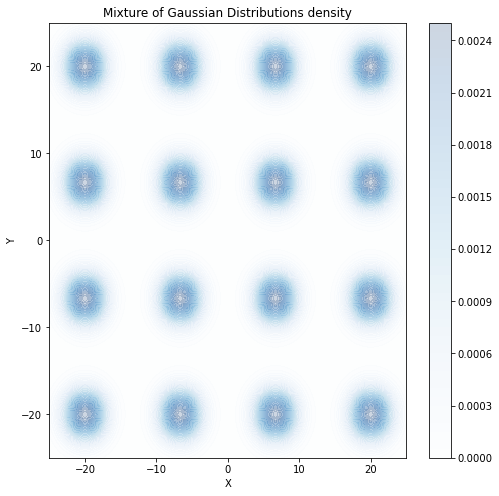

In [94]:
generate_multimodal(centers, [covariance]*16, [1/16]*16)

In [4]:
def evaluate_gaussian_mixture(x, weights, centers, covariances): 
    
    n_components = len(weights)

    pdf = np.zeros(1)

    for i in range(n_components):
        center = centers[i]
        covariance = covariances[i]
        weight = weights[i]

        rv = multivariate_normal(center, covariance) # On fixe la normale
        pdf += weight * rv.pdf(x) # On évalue la densité de cette loi sur la grille des points et on somme (pondéremment)

    return pdf[0]

In [26]:
evaluate_gaussian_mixture(np.array([0]), np.array([1]), np.array([0]), np.array([1]))

0.3989422804014327

In [5]:
def log_density_mixture(x, weights, centers, covariances): 
    
    return np.log(evaluate_gaussian_mixture(x, weights, centers, covariances))


In [190]:
log_density_mixture(np.array([0]), np.array([1]), np.array([0]), np.array([1]))

-0.9189385332046727

#### Gradient of the score of a multimodal : 

$ \nabla \log f(x)$ is computed as follow : 

$ \nabla \log f(x) = \sum_{i=1}^{k} \frac{w_i}{f(x)} \cdot \Sigma_i^{-1} (x - \mu_i) \cdot \mathcal{N}(x \mid \mu_i, \Sigma_i) $

Where :
- $ f(x) $ is the density of the multimodal distribution

----> Ecrire la suite sur le fait que l'on prend le gradient du score de l'échantillon de taille n qui donc est la somme des log(f(x_i)), où chacun des f(x_i) est la densité d'une multimodale composée d'une somme équipondérée de normales dont les centres sont différents mais la covariance est la même. 

------------------------------------------------------------------------------------------------------------------------------------------------------
We define a function which computes to score vector of a Gaussian Mixture distribution given its parameters : 

In [6]:
def grad_multimodal(x, weights, centers, covariances, manual = 1): 
    
    n_components = len(weights)

    if len(centers) != n_components or len(covariances) != n_components:
        raise ValueError("The number of weights, means and covariances should be the same")
    
    if manual == 1:

        gradient = np.zeros(x.shape)
        
        for i in range(n_components):
            center = centers[i]
            covariance = covariances[i]
            weight = weights[i]

            rv = multivariate_normal(center, covariance)
            pdf = rv.pdf(x)

            if x.shape[0] == 1:
                cov_inv = 1 / covariance
                diff = (x - center)[0]

                gradient += weight * (cov_inv * diff) * pdf
                
            else: 
                
                cov_inv = np.linalg.inv(covariance)
                diff = x - center

                gradient += weight * (cov_inv @ diff) * pdf
            
        return gradient / evaluate_gaussian_mixture(x, weights, centers, covariances)
    
    elif manual == 2: 
        
        gradient = np.zeros_like(x)
        
        for i in range(n_components):
            center = centers[i]
            covariance = covariances[i]
            weight = weights[i]
            
            rv = multivariate_normal(center, covariance)
            pdf = np.array(rv.pdf(x))
            
            inv_cov = np.linalg.inv(covariance)
            diff = x - center
            
            gradient += weight * (pdf[:, np.newaxis] * (diff @ inv_cov.T))
            #gradient += weight * (pdf * (diff @ inv_cov.T))
        
        mixture_pdf = evaluate_gaussian_mixture(x, weights, centers, covariances)
        #gradient /= mixture_pdf[:, np.newaxis]
        gradient /= mixture_pdf

        return gradient
    
    else: 

        pdf = evaluate_gaussian_mixture(x, weights, centers, covariances)
        log_density = np.log(pdf)
        print(pdf, log_density)
        
        gradient = np.gradient(log_density)
        
        return gradient

    

In [5]:
grad_multimodal(np.array([2, 2]), np.array([0.5, 0.5]), np.array([[0, 0], [1,1]]), np.array([[[10, 0], [0, 10]]]*2))

array([0.14255575, 0.14255575])

### Unadjusted Langevin Algorithm

Description of the idea : Blabla

------------------------------------------------------------------------------------------------------------------------------------------------------
We define a function for the Unadjusted Langevin Algorithm given : 
- The initial position of the particle $ x_o $ (in our case drawn from a standard Gaussian distribution)
- The parameters of the gaussian mixture (just used to compute the score vector because we consider that we cannot have access to samples of the target distribution)
- The number of iterations until we stop the algorithm
- The step size (considered constant here because "Unadjusted")

In [7]:
# We define the Unadjusted Langevin Algorithm (constant step + non stochastic gradient)

def ULA(x_init, n_iter, step, weights, centers, covariances): 
    
    n_components = len(weights)

    x = x_init # Initialisation with a 2-dimensional standerd normal distribution
    size_sample = x_init.shape[0]

    #x_tab = np.zeros((n_iter, size_sample))
    x_tab = []

    for i in tqdm(range(n_iter)):

        # Each iteration we compute the gradient of the target distribution and update the position of the particle
        grad = np.zeros(2)

        for element in x:
            grad += grad_multimodal(element, weights, centers, covariances) 

        x_new = []

        for element in x:     
            element = element + step * grad + np.sqrt(2 * step) * np.random.normal(size=2)
            x_new.append(element)
        
        x = x_new

        x_tab.append(x_new)
    
    return x_tab

Here is the true function : (the other is false)

In [8]:
# We define the Unadjusted Langevin Algorithm (constant step + non stochastic gradient)

def ULA_true(x_init, nb_iter, step, weights, centers, covariances): 
    
    # Number of components of the Gaussian Mixture
    n_components = len(weights)

    dim_var = x_init.shape[0]

    x_tab = []

    x = x_init # Initialisation with a 2-dimensional standerd normal distribution

    for i in tqdm(range(nb_iter)):

        # Each iteration we compute the gradient of the target distribution and update the position of the particle
        grad = grad_multimodal(x, weights, centers, covariances, 1) 

        #x = x + step * grad + np.sqrt(2 * step) * np.random.normal(size=dim_var)
        x = x - step * grad + np.sqrt(2 * step) * np.random.normal(size=dim_var)

        x_tab.append(x)
    
    return x_tab

Definition of the parameters of the experiment : 
- 1000 particles 
- 10000 iterations
- step size of 0.001 (constant)
- Linear Schedule : $ \forall \mathbb{t} \in \mathbb{R^+} , \lambda_t = \min(1, \mathbb{t}) $


In [9]:
x = np.linspace(-20, 20, 4)
y = np.linspace(-20, 20, 4)

nb_particles = 20

xx, yy = np.meshgrid(x, y)

# We define the centers for each mode
centers = np.c_[xx.ravel(), yy.ravel()] ## On a une matrice de 16 lignes et 2 colonnes, chaque ligne correspond à un centre

# Define the covariance matrix
covariances = np.array([[[10, 0], [0, 10]]]*16)  # cov = 10*I_2 -> 16 times the same covariance matrix
weights = np.ones(16) / 16

# We define the initial position of the particles (sample from a standard normal distribution in 2-dimensions)
sample_init = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], nb_particles)

We apply the ULA algorithm to each particle and simply return a vector containing the final position of each particle : 

In [40]:
x_result = []

for j in tqdm(range(20)): 

    x_init = sample_init[j, :]

    traj = ULA_true(x_init, 10000, 0.001, weights, centers, covariances)

    x_result.append(traj[-1])


100%|██████████| 20/20 [19:33<00:00, 58.68s/it]


Comportement d'une particule dans le temps pour 30,000 itérations : 

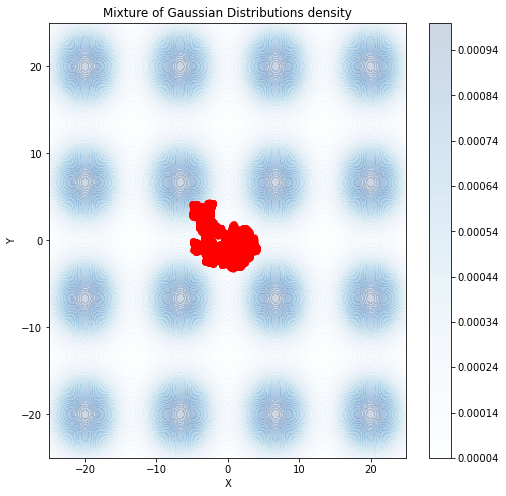

In [33]:
generate_multimodal(centers, covariances, weights, np.array(traj))

Comportement d'une particule dans le temps pour 60,000 itérations : 

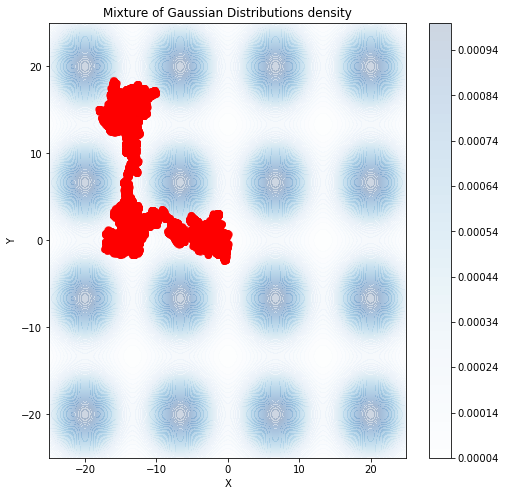

In [35]:
generate_multimodal(centers, covariances, weights, np.array(traj))

Gradient descent et non ascent avec 60,000 itérations : 

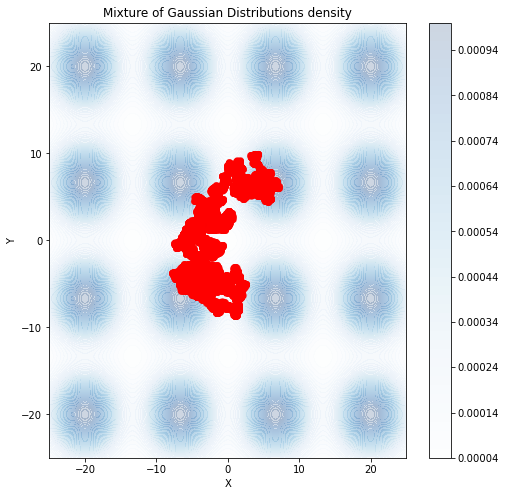

In [38]:
generate_multimodal(centers, covariances, weights, np.array(traj))

Résultat pour 15,000 itérations de 10 particules avec l'Algo ULA -> pas de convergence at all...

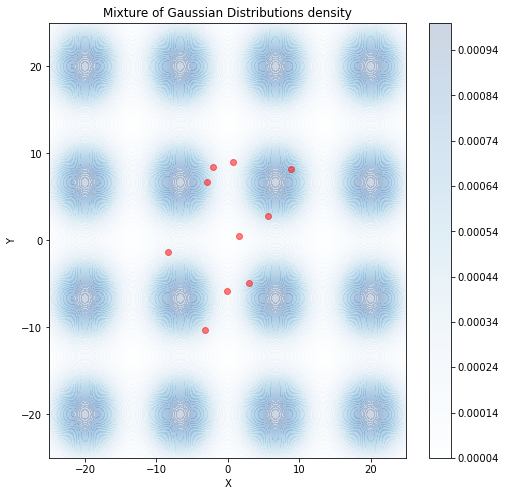

In [210]:
generate_multimodal(centers, covariances, weights, np.array(x_result))

Autre résultat avec 10,000 itérations et 10 particules -> same

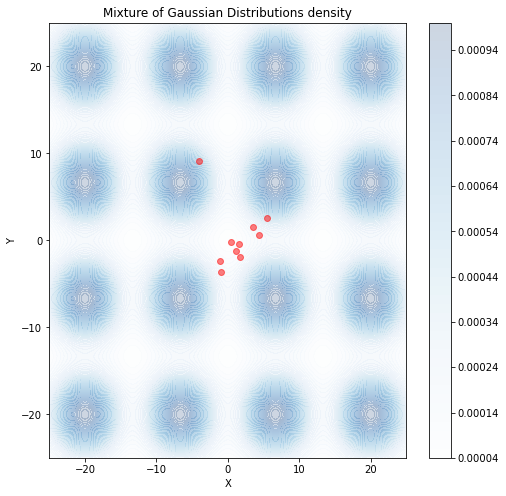

In [208]:
generate_multimodal(centers, covariances, weights, np.array(x_result))

Autre résultat avec 10,000 itérations et 20 particules et gradient descent et non ascent: 

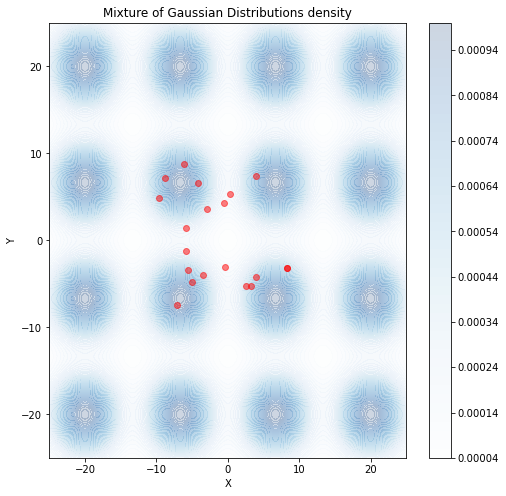

In [41]:
generate_multimodal(centers, covariances, weights, np.array(x_result))

We define a function that directly plots the result of the experiement for the ULA, given the parameters : 
- Parameters of the target Gaussian Mixture (centers, weights and covariances)
- Number of iterations 
- Step size (constant)
- Number of particles

(Works only in two dimensions)

In [10]:
def plot_ULA(nb_particles, step, nb_iter, weights, centers, covariances): 

    ## Initialisation : for the moment manually

    sample_init = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], nb_particles)

    x_result = []

    for j in tqdm(range(nb_particles)): 

        x_init = sample_init[j, :]

        traj = ULA_true(x_init, nb_iter, step, weights, centers, covariances)

        x_result.append(traj[-1])

    generate_multimodal(centers, covariances, weights, np.array(x_result))

### Dilation Path

Description de la technique : 

------------------------------------------------------------------------------------------------------------------------------------------------------
We define a function for the Unadjusted Langevin Algorithm, with Dilation Path. It means that we apply the same equation to update the position of each particle (not-stochastic, constant step size, ...), but with intermediate distributions. 

The parameters of the algo : 
- The initial position of the particle $ x_o $ (in our case drawn ...)
- The parameters of the gaussian mixture (just used to compute the score vector because we consider that we cannot have access to samples of the target distribution and we can apply the algo by just being able to compute a score vector)
- The number of iterations until we stop the algorithm
- The step size (considered constant here because "Unadjusted")

In [11]:
def dilation_path(x_init, weights, centers, covariances, step, n_iter): 
    
    dim_var = x_init.shape[0]

    x_tab = []

    x = x_init # Initialisation with a 2-dimensional standerd normal distribution

    time = 0

    for i in tqdm(range(n_iter)):
        
        time = (i+1)*step
        schedule = min(1, time)

        # Each iteration we compute the gradient of the target distribution and update the position of the particle
        grad = (1 / np.sqrt(schedule)) * grad_multimodal(x / np.sqrt(schedule), weights, centers, covariances, 1)

        x = x - step * grad + np.sqrt(2*step) * np.random.normal(size=dim_var)

        x_tab.append(x)
    
    return x_tab

We keep the same parameters than the previous case (ULA), except for the initialisation that we manually set as $ x_0 = (0,0)$ (question about it)

------------------------------------------------------------------------------------------------------------------------------------------------------
Let's define a function that plots the result of the ULA, with the dilation path, given the parameters : 
- Parameters of the target Gaussian Mixture (centers, weights and covariances)
- Number of iterations 
- Step size (constant)
- Number of particles

In [12]:
def plot_ULA_dilation(nb_particles, step, nb_iter, weights, centers, covariances): 

    ## Initialisation : for the moment manually

    sample_init = np.array([0,0]*nb_particles).reshape(nb_particles, 2)

    x_result = []

    for j in tqdm(range(nb_particles)): 

        x_init = sample_init[j, :]

        traj = dilation_path(x_init, weights, centers, covariances, step, nb_iter)

        x_result.append(traj[-1])

    generate_multimodal(centers, covariances, weights, np.array(x_result))

In [67]:
nb_particles = 20

# We define the initial position of the particles (sample from a standard normal distribution in 2-dimensions)
sample_init = np.array([0,0]*nb_particles).reshape(nb_particles, 2)

In [68]:
x_result = []

for j in tqdm(range(nb_particles)): 

    x_init = sample_init[j, :]
    traj = dilation_path(x_init, weights, centers, covariances, 0.001, 5000)

    x_result.append(traj[-1])

100%|██████████| 20/20 [30:59<00:00, 92.98s/it] 


20 particles and 5000 iterations : Dilation Path

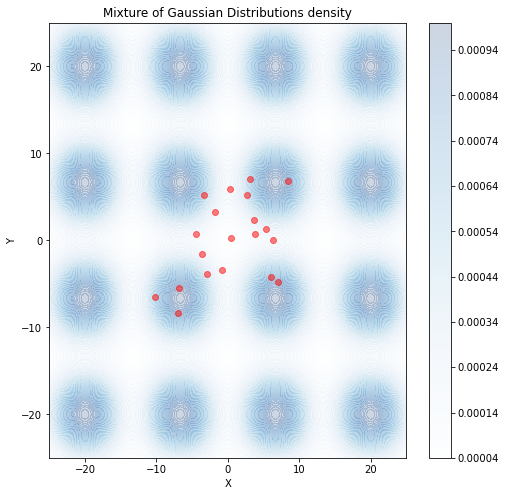

In [70]:
generate_multimodal(centers, covariances, weights, np.array(x_result))

### ULA with geometric path

Description : 

------------------------------------------------------------------------------------------------------------------------------------------------------
As previously, we define a function to run the ULA, with geometric path for one particle. We also define the function to plot the result and we have the same parameters as previously

In [13]:
def ULA_geometric(x_init, weights, centers, covariances, step, n_iter): 
    
    dim_var = x_init.shape[0]

    x_tab = []

    x = x_init # Initialisation with a 2-dimensional standerd normal distribution

    time = 0

    for i in tqdm(range(n_iter)):
        
        time = (i+1)*step
        schedule = min(1, time)

        # Each iteration we compute the gradient of the target distribution and update the position of the particle
        grad = schedule * grad_multimodal(x, weights, centers, covariances, 1) + (1 - schedule) * x

        x = x - step * grad + np.sqrt(2*step) * np.random.normal(size=dim_var)

        x_tab.append(x)
    
    return x_tab

In [14]:
def plot_ULA_geom(nb_particles, step, nb_iter, weights, centers, covariances): 

    ## Initialisation : for the moment manually

    sample_init = np.random.multivariate_normal(np.array([0, 0]), np.array([[1, 0], [0, 1]]), nb_particles)

    x_result = []

    for j in tqdm(range(nb_particles)): 

        x_init = sample_init[j, :]

        traj = ULA_geometric(x_init, weights, centers, covariances, step, nb_iter)

        x_result.append(traj[-1])

    generate_multimodal(centers, covariances, weights, np.array(x_result))

100%|██████████| 5/5 [08:47<00:00, 105.47s/it]


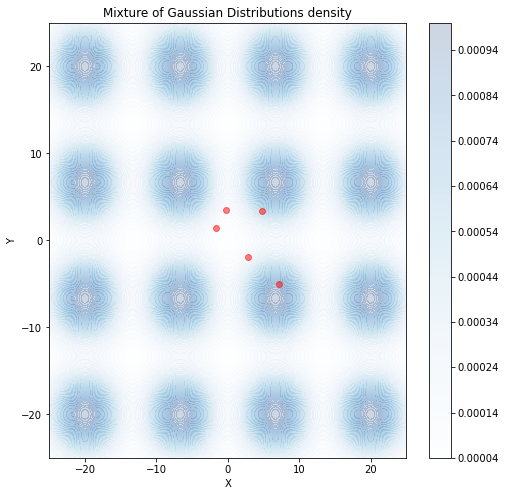

In [75]:
plot_ULA_geom(5, 0.001, 5000, weights, centers, covariances)

------------------------------------------------------------------------------------------------------------------------------------------------------
Let's plot the same graphs as in the article : 

### II. 40-modes Gaussian Mixture

In this part, we will reproduce the second part of the experiment. All the parameters of the experiement are the same as previously except the parameters of the target distribution : 40 modes and the no longer equally-weighted. 

In [114]:
## Let's set the parameters of the new target : 

weights = np.random.uniform(0, 1, 40)
weights = weights / np.sum(weights)

centers = np.random.uniform(-50, 50, (40, 2))

covariances = np.array([[10, 0], [0, 10]] * 40).reshape((40, 2, 2)) #10*I_2 pour chaque composante de la Mixture

nb_particles = 5

step = 0.001

nb_iter = 5000
                           

100%|██████████| 5/5 [08:43<00:00, 104.73s/it]


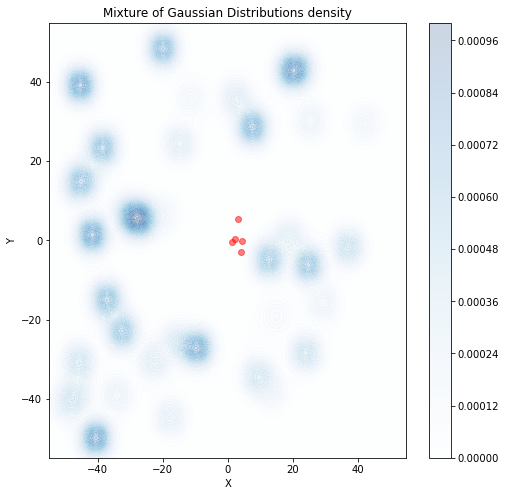

In [117]:
plot_ULA(nb_particles, step, nb_iter, weights, centers, covariances)

100%|██████████| 5/5 [17:21<00:00, 208.30s/it]


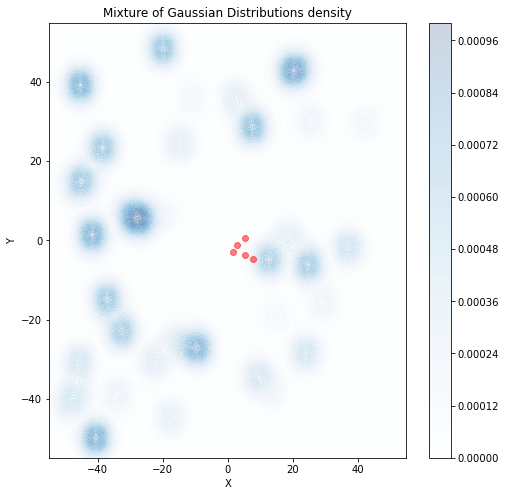

In [118]:
plot_ULA_geom(nb_particles, step, nb_iter, weights, centers, covariances)

100%|██████████| 5/5 [13:40<00:00, 164.12s/it]


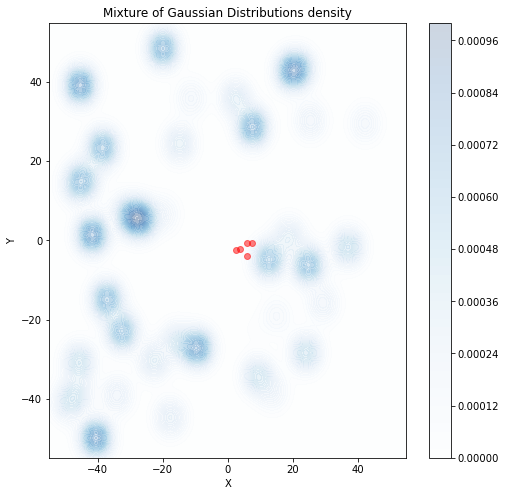

In [119]:
plot_ULA_dilation(nb_particles, step, nb_iter, weights, centers, covariances)

### Statistical divergences used for evaluation

In this section we define different convergence metrics to measure the discrepancy between the target distribution $\pi$ and the intermediate distributions $\mu_t$ that we use at each iteration. For this we will use an approximation of several statistical divergences, built from samples of the target distribution $\pi$ and from each intermediate distribution. 

------------------------------------------------------------------------------------------------------------------------------------------------------
First, let's define the Kernel Stein Discrepancy (KSD), defined as : 

$ \text{KSD}^2(p_k, \pi) = \mathbb{E}_{(x, x') \sim p_k \otimes p_k} [K(x, x'; \pi, K')] $

where : 
- $K(.)$ is a Kernel that requires the unormalized target distribution and another Kernel $K'(.)$ 

It is defined as : 

$ K(x, y; \pi, K') = \nabla \log \pi(x)^T \nabla \log \pi(y) K'(x, y) + \nabla \log \pi(x)^T \nabla_y K'(x, y) + \nabla_x K'(x, y)^T \nabla \log \pi(y) + \nabla_x \cdot \nabla_y K'(x, y) $

- $K'(.)$ is the Inverse Multiquadratic Kernel, defined as : 

$ K'(x, y) = (1 + \|x - y\|^2)^{-\beta} \quad \text{where} \ \beta \in [0, 1] \ \text{and is here chosen as} \ 0.5 $

We define both Kernels and then a function that takes as arguments the parameters of the target distribution (Gaussian Mixture) and a sample from the intermediate distribution (whose items are consider independant)



In [33]:
def multiquad_kernel(x, y, beta = 0.5): 

    if len(x) != len(y): 
        raise ValueError('Given vectors have not the same dimension')
    
    norm = sum((x - y) ** 2)

    return (1 + norm) ** (-beta)

In [34]:
multiquad_kernel(np.array([1,0]), np.array([2,2]), -2)

36

To compute the second kernel value, we need to compute the gradients of the Multiquadratic Kernel w.r.t $x$ and $y$, given by : 

- $ \nabla_x K'(x, y) = -2 \beta (1 + \|x - y\|^2)^{-\beta-1} (x - y) $  
- $\nabla_y K'(x, y) = 2 \beta (1 + \|x - y\|^2)^{-\beta-1} (x - y)$


In [37]:
def grad_multiquad_kern(x, y, beta=0.5):

    diff = x - y

    #Returns an array with the gradient w.r.t x and w.r.t y

    return [(-2*beta) * multiquad_kernel(x, y, beta + 1) * diff , (2*beta) * multiquad_kernel(x, y, beta + 1) * diff]

In [36]:
grad_multiquad_kern(np.array([1,0]), np.array([2,2]))

[array([0.06804138, 0.13608276]), array([-0.06804138, -0.13608276])]

In [41]:
def compute_kernel(x, y, weights, centers, covariances, beta = 0.5): 

    dim_var = x.shape[0]

    nb_components = len(weights)

    if y.shape[0] != dim_var: 
        raise ValueError('Dimension problem : the two vectors have different dimensions')
    
    elif len(centers) != nb_components or len(covariances) != nb_components:
        raise ValueError('Dimension problem : parameters of the target distribution have different lenths')
    
    grad_vect_1 = grad_multimodal(x, weights, centers, covariances)
    
    grad_vect_2 = grad_multimodal(y, weights, centers, covariances)

    kernel = multiquad_kernel(x, y, beta)

    grad_ = grad_multiquad_kern(x, y, beta)

    grad_MK_x = grad_[0]

    grad_MK_y = grad_[1]

    return kernel * (grad_vect_1.T @ grad_vect_2) + (grad_vect_1.T @ grad_MK_y) + (grad_MK_x.T @ grad_vect_2) + (grad_MK_x.T @ grad_MK_y)

In [42]:
compute_kernel(np.array([1,0]), np.array([2,2]), weights, centers, covariances, beta = 0.5)

-0.03632778332938214

In [78]:
def squared_KSD(intermediate_sample, weights, centers, covariances, beta = 0.5): 

    nb_components = len(weights)

    sample_size = len(intermediate_sample)

    sample_split_size = int(sample_size // 2)

    print(type(sample_size))

    if len(centers) != nb_components or len(covariances) != nb_components: 
        raise ValueError('Dimension problem : parameters of the target distribution have different lenths')

    ## On scinde l'échantillon en deux échantillons distincts, issus de la distribution intermédiaire et dont chaque réalisation est indépendente
    if sample_size % 2 == 1:

        intermediate_sample = intermediate_sample[:-1]

    sample_1 = intermediate_sample[:-sample_split_size]
    sample_2 = intermediate_sample[sample_split_size:]

    estimator = 0

    for i in tqdm(range(sample_split_size)): 

        vect_1 = sample_1[i, :]
        vect_2 = sample_2[i, :]

        estimator += compute_kernel(vect_1, vect_2, weights, centers, covariances, beta)
    
    return estimator / sample_split_size

In [79]:
intermediate_sample = np.random.multivariate_normal(np.array([0,0]), np.array([[1,0], [0,1]]), 10).reshape(10, 2)

In [80]:
squared_KSD(intermediate_sample, weights, centers, covariances, beta = 0.5)

<class 'int'>


100%|██████████| 5/5 [00:00<00:00, 32.24it/s]


-0.10784803113984484

Calculs précédents à vérifier

------------------------------------------------------------------------------------------------------------------------------------------------------
We define the Kullbach-Leibler divergence between two distributions, given by : 

$ \text{KL}(p_k, \pi) = \mathbb{E}_{x \sim p_k} \left[ \log \frac{p_k(x)}{\pi(x)} \right] $

We can have the rev-KL by switching the roles of $p_k$ and $\pi$ 

Est-ce qu'on peut même le coder sans coder la log densité de $p_k$ ????????


In [82]:
def KL(intermediate_sample, weights, centers, covariances, reverse = False): 

    return '??'

Example of how to use the scipy KL : 

In [87]:
P = [0.3, 0.5, 0.2]   # Distribution P
Q = [0.2, 0.6, 0.2]   # Distribution Q

# Calcul de la KL divergence de P par rapport à Q
kl_divergence = entropy(pk=P, qk=Q)
kl_divergence

0.03047875403547197

In [89]:
def KL_divergence(distrib_P, distrib_Q): 
    
    return entropy(pk=distrib_P, qk=distrib_Q)

Same with the Wasserstein Distance : 

In [88]:
distance = wasserstein_distance(P, Q)
distance

0.06666666666666665

In [90]:
def wasser_dist(distrib_P, distrib_Q): 

    return wasserstein_distance(distrib_P, distrib_Q)

We skip Maximum Mean Discrepancy (MMD) 

We define the Multimodality Score (MMS) : 

Est ce que l'expected particle by mode c'est bien les poids ? 

In [92]:
def MMS(intermediate_sample, weights, centers):

    nb_components = len(weights)

    sample_size = len(intermediate_sample)

    if len(centers) != nb_components: 
        raise ValueError('Dimension Problem')

    particle_by_mode = np.zeros(nb_components)

    for i in tqdm(range(sample_size)): 
        
        item = intermediate_sample[i]
        dist = []

        for j in range(nb_components): 

            center = centers[j]

            dist.append(sum((center - item) ** 2))

        mode = np.argmax(dist)

        particle_by_mode[mode] += 1

    return np.sqrt(np.mean((particle_by_mode - weights) ** 2))

In [96]:
MMS([0,0], weights, centers)

100%|██████████| 2/2 [00:00<00:00, 167.29it/s]


0.4881406047441659